# Photometry - Calculating Zero Points

Once you've measured how much light you received from a star, the next step is to figure out what that means in calibrated units - i.e., what you would have observed if there were no inefficiencies caused by the instrument or atmosphere.

This calibration process is critical for comparing observations!

For more details, have a look at [Stuart Littlefair's detailed description](http://slittlefair.staff.shef.ac.uk/teaching/phy217/lectures/principles/L04/index.html#stacks_out_1244_page13).

Learning goals are:
 
  * Practice looking up stars
  * Practice photometry measurement
  * Learn to use magnitude measurements to determine the magnitude zero-point for an observation
  

# Index

* [Repeat Basic Photometry, but faster](#Step-1:-Repeat-all-operations-from-"Basic-Photometry"-exercise)
* [Select stars](#Find-all-stars-we-want-to-measure)
* [Measure Photometry](#Measure-Photometry)
* [Finder Chart Matching](#Finder-chart-matching:-Look-up-the-stars)
* [Add coordinates to table](#Add-star-coordinates-to-our-table)
* [Look up stars: SIMBAD](#Look-up-stars:-SIMBAD)
* [Look up stars: Vizier](#Look-up-stars:-Vizier)
* [Build Calibration Table](#Build-Calibration-Table)
* [Magnitude Zero Point](#Magnitude-Zero-Point)
* [Sky Brightness](#Estimate-the-Sky-Background)
* [End](#End)

In [1]:
%matplotlib

Using matplotlib backend: <object object at 0x10856afa0>


In [2]:
import numpy as np
import pylab as pl
pl.rcParams['image.origin'] = 'lower' # make images display right-side-up
pl.style.use('dark_background')

## Step 1: Repeat all operations from "Basic Photometry" exercise

[Index](#Index)

If you saved your dark- and sky-subtracted, flat-fielded image, you could just load that up here instead.

In [3]:
from astropy.io import fits
import os

In [4]:
# on my computer, the data are in a subdirectory called 'data/', so I chdir there
os.chdir('data_mar8_2021/')

In [5]:
pleiades_clear_darksub_flattened = fits.getdata('pleiades_30s_C_other_001_darksub_flattened.fits')
pleiades_clear_darksub_flattened_uncertainty = fits.getdata('pleiades_30s_C_other_001_darksub_flattened_uncertainty.fits')

In [6]:
sky_mean = pleiades_clear_darksub_flattened.mean()
sky_median = np.median(pleiades_clear_darksub_flattened)
print(sky_mean, sky_median)

1035.2701922573067 1034.4351460591995


In [7]:
sky_stddev = pleiades_clear_darksub_flattened.std() # estimate of the per-pixel error
print(f"Standard deviation of the data: {sky_stddev:0.1f}")
print(f"Average of the per-pixel uncertainty from error propagation: {pleiades_clear_darksub_flattened_uncertainty.mean():0.1f}")

Standard deviation of the data: 53.1
Average of the per-pixel uncertainty from error propagation: 41.3


In [8]:
sky_subtracted_pleiades_clear = pleiades_clear_darksub_flattened - sky_mean

# Find all stars we want to measure
[Index](#Index)

The process is:

 * Show an image
 * Look at the image and identify some stars
 * Record the X,Y coordinates of the stars
 

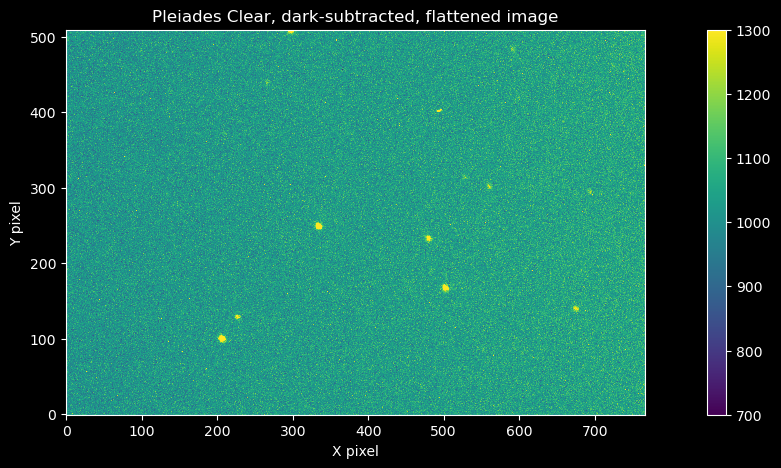

In [9]:
pl.figure(figsize=(16,5))
im = pl.imshow(pleiades_clear_darksub_flattened, origin='lower', interpolation='none', vmax=1300, vmin=700)
pl.colorbar(im)
_=pl.title("Pleiades Clear, dark-subtracted, flattened image")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")

In [10]:
star_centers = [[502,168], [335,250], [203,102], [228,130], [477,233], [673,140]]
width = 20
height = 20

To show where we found stars, we draw boxes around each of them.

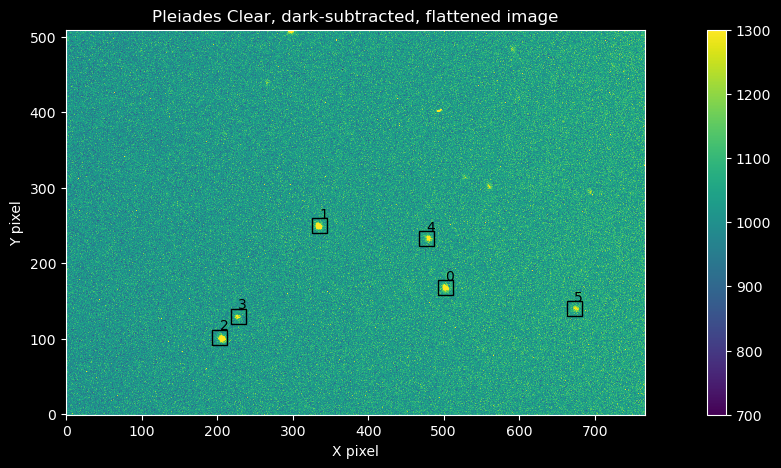

In [11]:
fig = pl.figure(figsize=(16,5))
ax = fig.gca()
im = pl.imshow(pleiades_clear_darksub_flattened, 
               origin='lower', interpolation='none', vmax=1300, vmin=700)
pl.colorbar(im)
_=pl.title("Pleiades Clear, dark-subtracted, flattened image")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")
for ii,(xcen, ycen) in enumerate(star_centers):
    rect = pl.Rectangle(xy=[xcen-width/2, ycen-height/2],
                            width=width, height=height,
                        facecolor='none', edgecolor='k')
    ax.add_patch(rect)
    ax.text(xcen, ycen+height/2, str(ii), color='k')

# Measure Photometry

[Index](#Index)

Using the tools we made at the end of the photometry notebook (`BasicPhotometry.ipynb`), we can measure the stars' counts.

In [12]:
def calculate_star_flux_and_error(cutout_star, cutout_uncertainty, sky_stddev):

    mask = cutout_star > 2*sky_stddev
    masked_star_sum = cutout_star[mask].sum()
    masked_star_sum_error = ((cutout_uncertainty[mask]**2).sum() + sky_stddev**2*mask.sum())**0.5
 
    return masked_star_sum, masked_star_sum_error

In [13]:
star_centers

[[502, 168], [335, 250], [203, 102], [228, 130], [477, 233], [673, 140]]

In [14]:
# the // means "divide by two, but return an integer (instead of a float)"
# single / means "divide by, then return a float"
502//2

251

In [15]:
# we are going to use cutouts around the star for their measurements
for (xc, yc) in star_centers:
    slc = slice(yc-height//2,yc+height//2),slice(xc-width//2,xc+width//2)
    print(slc)

(slice(158, 178, None), slice(492, 512, None))
(slice(240, 260, None), slice(325, 345, None))
(slice(92, 112, None), slice(193, 213, None))
(slice(120, 140, None), slice(218, 238, None))
(slice(223, 243, None), slice(467, 487, None))
(slice(130, 150, None), slice(663, 683, None))


There are two equivalent syntaxes to make a cutout:

```python
sky_subtracted_pleiades_clear[158:178, 492:512]
sky_subtracted_pleiades_clear[slice(158,178), slice(492,512)]
```

These do the same thing.  The former is "syntactic sugar" for the latter (that's a technical term that you don't need to know but might be useful if you're googling)

Then, we use a list comprehension (an inline for loop) to:

1. loop over the star centers
2. for each star, make a cutout around the star
3. for each star, make a cutout _of the uncertainty map_ around the star
4. Pass the cutouts, along with the sky background standard deviation to `calculate_star_flux_and_error`

In [16]:
results = [calculate_star_flux_and_error(
    sky_subtracted_pleiades_clear[yc-height//2:yc+height//2,
                                  xc-width//2:xc+width//2],
    pleiades_clear_darksub_flattened_uncertainty[yc-height//2:yc+height//2,
                                                 xc-width//2:xc+width//2],
    sky_stddev)
           for (xc,yc) in star_centers]

It's a good idea to look at what we did.  We use another loop to show each of the cutout stars
along with a contour showing the mask we used.  We are reporting the sum over pixels contained within the mask:

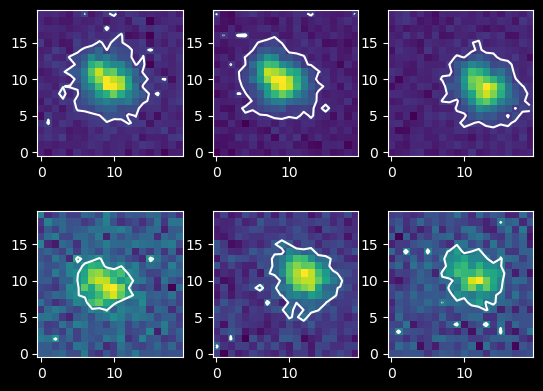

In [17]:
for ii,(xc, yc) in enumerate(star_centers):
    ax = pl.subplot(2,3,ii+1)
    cutout = sky_subtracted_pleiades_clear[yc-height//2:yc+height//2,
                                           xc-width//2:xc+width//2]
    ax.imshow(cutout)
    ax.contour(cutout, levels=[2*sky_stddev], colors=['w'])

We now add our results to a table to save them.

Astropy tables are useful tools for storing and displaying tabular data.

In [18]:
from astropy.table import Table

In [19]:
#conda update astropy
# if the above doesn't work, try uncommenting this to update astropy

We extract the flux and uncertainty measurements from the `results` variable, which is a 2-dimensional array.

The `.T` here means "transpose".  The fluxes and uncertainties are presently in columns, e.g.:
```
[[1,2],
 [3,4],
 [5,6]]
``` 
 
But we want to put them into _rows_ so we can make a table out of them.  This is the transpose:
```
[[1,2,3],
 [4,5,6]]
```

In [20]:
fluxes, uncertainties = np.array(results).T

We then make a table with three columns: the star number, the fluxes, and the uncertainties

In [21]:
Table([np.arange(len(fluxes)), fluxes, uncertainties], names=['Star Number', 'Flux', 'Uncertainty'])

Star Number,Flux,Uncertainty
int64,float64,float64
0,35316.171723260944,700.1730852477532
1,40898.35182370345,696.7739320352291
2,39515.094791662916,668.7418749842822
3,8163.221738016467,435.2032709336745
4,18341.568210431433,582.6446125975509
5,10853.453148936136,533.3646210877812


# Finder chart matching: Look up the stars

[Index](#Index)

We now have measurements of 6 stars.  We need to calibrate them by looking up known photometric measurements in a catalog.  To do this, we have to figure out which stars they are!

This is probably best done using ds9 (demo recording [here](https://ufl.zoom.us/rec/play/Wny4jrohY1fctEe_LXqd2REM6NRtU8qr8RnaJztB7ymMd5Jj_gCYf1eAleMjAJsckNP9pvHLdNIOttxw.Ynu6Jk2VQtF1pzA_?continueMode=true&_x_zm_rtaid=h4gsRRw_QbugEy3jXCpJFw.1616984572261.b538290e278028974fddf4726ac67d54&_x_zm_rhtaid=28)), but I'll show how to do this in the notebook below.

In [22]:
from astroplan.plots import plot_finder_image
from astropy import units as u
from astropy.coordinates import SkyCoord

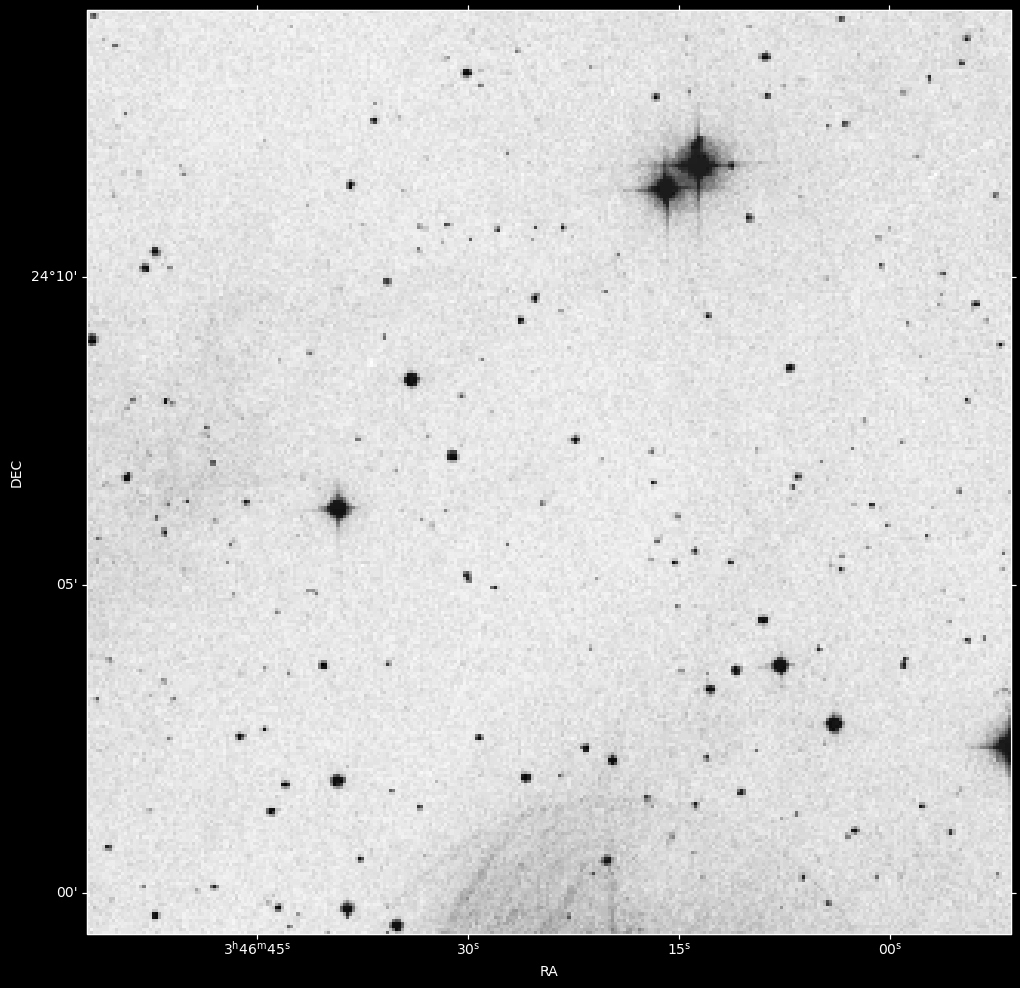

In [23]:
pl.figure(figsize=(12,12))
ax, hdu = plot_finder_image(SkyCoord.from_name('Pleiades'), survey='DSS', fov_radius=15*u.arcmin)

I found the stars by eye and matched them up to real coordinates using a finder chart loaded in ds9.

Record the stars' real coordinates:

In [24]:
star_coordinates = SkyCoord("""3:47:03.5093 +24:09:36.041
3:46:56.8012 +24:08:58.195
3:46:52.2998 +24:10:23.754
3:46:52.9937 +24:10:07.865
3:47:02.5002 +24:08:59.299
3:47:10.3589 +24:09:40.857""".split("\n"), frame='fk5', unit=(u.hour, u.deg))
star_coordinates

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    [(56.76462208, 24.16001139), (56.73667167, 24.14949861),
     (56.71791583, 24.173265  ), (56.72080708, 24.16885139),
     (56.7604175 , 24.14980528), (56.79316208, 24.16134917)]>

The astropy coordinates package can understand strings like we wrote them above.

We can also enter the coordinates in other ways:

In [25]:
SkyCoord("3:47:03.59", "24:09:36", unit=(u.hour, u.deg))

<SkyCoord (ICRS): (ra, dec) in deg
    (56.76495833, 24.16)>

We could even do the math ourselves:

In [26]:
SkyCoord(3+47/60+3.59/3600, "24:09:36", unit=(u.hour, u.deg)).to_string('hmsdms')

'03h47m03.59s +24d09m36s'

We can plot the stars' coordinates on top of the finder chart to prove we got them right:

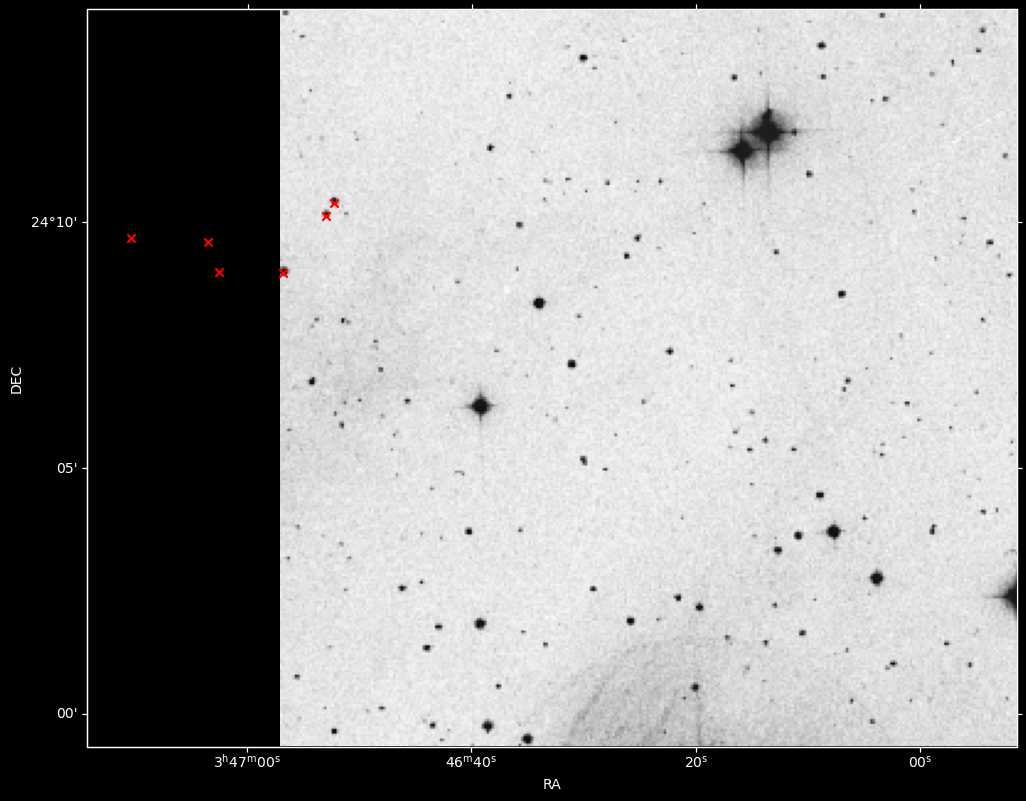

In [27]:
pl.figure(figsize=(12,12))
ax, hdu = plot_finder_image(SkyCoord.from_name('Pleiades'), survey='DSS', fov_radius=15*u.arcmin)
ax.scatter(star_coordinates.ra.deg, star_coordinates.dec.deg, transform=ax.get_transform('fk5'), marker='x', color='r')

# Add star coordinates to our table
[Index](#Index)

Now that we've identified the stars, we want to make a new table that includes the stars' true coordinates as one of the columns:

In [28]:
Table([np.arange(len(fluxes)), fluxes, uncertainties, star_coordinates.ra, star_coordinates.dec],
      names=['Star Number', 'Flux', 'Uncertainty', 'RA', 'Dec'])

Star Number,Flux,Uncertainty,RA,Dec
,,,deg,deg
int64,float64,float64,float64,float64
0,35316.171723260944,700.1730852477532,56.76462208333332,24.160011388888886
1,40898.35182370345,696.7739320352291,56.73667166666666,24.14949861111111
2,39515.094791662916,668.7418749842822,56.71791583333332,24.173265
3,8163.221738016467,435.2032709336745,56.72080708333333,24.16885138888889
4,18341.568210431433,582.6446125975509,56.76041749999999,24.149805277777777
5,10853.453148936136,533.3646210877812,56.79316208333332,24.161349166666664


# Look up stars: SIMBAD
[Index](#Index)

Now we can look up the stars.

This process is similar to what we did in the Observation Planning notebooks.

In [29]:
from astroquery.simbad import Simbad

In [33]:
Simbad.reset_votable_fields()

Simbad.add_votable_fields('flux(B)', 'flux(V)', 'flux(I)')

In [35]:
simbad_rslt = Simbad.query_region(star_coordinates[0], radius=2*u.arcsec)
simbad_rslt

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,FLUX_B,FLUX_V,FLUX_I,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,mag,mag,mag,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float32,float32,float32,int32
V* V535 Tau,03 47 03.5824,+24 09 34.870,14,14,0.019,0.015,90,A,O,2020yCat.1350....0G,15.93,14.58,12.72,1


In [38]:
mags_star0 = simbad_rslt[['FLUX_B', 'FLUX_V', 'FLUX_I']]
mags_star0

FLUX_B,FLUX_V,FLUX_I
mag,mag,mag
float32,float32,float32
15.93,14.58,12.72


The second star doesn't have fluxes in the SIMBAD catalog:

In [39]:
Simbad.query_region(star_coordinates[1], radius=2*u.arcsec)

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,FLUX_B,FLUX_V,FLUX_I,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,mag,mag,mag,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float32,float32,float32,int32
HAT 260-09130,03 46 56.8046,+24 08 58.140,14,14,0.085,0.065,90,A,O,2020yCat.1350....0G,--,--,--,1


# Look up stars: Vizier
[Index](#Index)

We can try a specific Vizier catalog:

In [40]:
from astroquery.vizier import Vizier

In [41]:
viz_result = Vizier.query_region(star_coordinates[1], radius=2*u.arcsec, catalog='I/322A/out')
viz_result

TableList with 1 tables:
	'0:I/322A/out' with 24 column(s) and 1 row(s) 

In [42]:
viz_result = Vizier.query_region('V1073 Ori', radius=15*u.arcsec, catalog='I/322A/out')
viz_result

TableList with 1 tables:
	'0:I/322A/out' with 24 column(s) and 1 row(s) 

In [43]:
viz_result[0]

UCAC4,RAJ2000,DEJ2000,ePos,f.mag,of,db,pmRA,pmDE,Jmag,Kmag,Bmag,Vmag,rmag,imag,H,A,b,h,Z,B,L,N,S
,deg,deg,mas,mag,,,mas / yr,mas / yr,mag,mag,mag,mag,mag,mag,,,,,,,,,
str10,float64,float64,int16,float32,uint8,int16,float64,float64,float32,float32,float32,float32,float32,float32,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8
423-010230,83.8684242,-5.4389753,55,9.921,1,0,-2.7,-2.8,9.386,9.315,9.711,9.712,9.799,9.757,0,1,0,0,1,1,0,0,0


In [44]:
mags_star1 = viz_result[0][['Bmag','Vmag','imag']]
mags_star1

Bmag,Vmag,imag
mag,mag,mag
float32,float32,float32
9.711,9.712,9.757


Rinse & repeat:

In [45]:
mags_for_stars = {}
for starnum in (0,1,2,3,4,5):
    viz_result = Vizier.query_region(star_coordinates[starnum], radius=2*u.arcsec, catalog='I/322A/out')
    mags_for_stars[starnum] = viz_result[0][['Bmag','Vmag','imag']]

In [46]:
mags_for_stars

{0: <Table length=1>
   Bmag    Vmag    imag 
   mag     mag     mag  
 float32 float32 float32
 ------- ------- -------
  16.022  14.658  13.308,
 1: <Table length=1>
   Bmag    Vmag    imag 
   mag     mag     mag  
 float32 float32 float32
 ------- ------- -------
  15.237  14.081  13.158,
 2: <Table length=1>
   Bmag    Vmag    imag 
   mag     mag     mag  
 float32 float32 float32
 ------- ------- -------
  14.591  13.887  13.350,
 3: <Table length=1>
   Bmag    Vmag    imag 
   mag     mag     mag  
 float32 float32 float32
 ------- ------- -------
      --      --      --,
 4: <Table length=1>
   Bmag    Vmag    imag 
   mag     mag     mag  
 float32 float32 float32
 ------- ------- -------
  15.093  14.623  14.338,
 5: <Table length=1>
   Bmag    Vmag    imag 
   mag     mag     mag  
 float32 float32 float32
 ------- ------- -------
      --      --      --}

Not all of the stars had good measurements.  We will ignore the stars that don't have measurements (that are masked) because we can't use them.

In [47]:
b_mags = [mags_for_stars[starnum]['Bmag'][0] for starnum in (0,1,2,3,4,5,)]
b_mags

[16.022, 15.237, 14.591, masked, 15.093, masked]

In [48]:
v_mags = [mags_for_stars[starnum]['Vmag'][0] for starnum in (0,1,2,3,4,5,)]
v_mags

[14.658, 14.081, 13.887, masked, 14.623, masked]

In [49]:
i_mags = [mags_for_stars[starnum]['imag'][0] for starnum in (0,1,2,3,4,5,)]
i_mags

[13.308, 13.158, 13.35, masked, 14.338, masked]

# Build Calibration Table

[Index](#Index)

In [50]:
cal_table = Table([np.arange(len(fluxes)), fluxes*u.electron, uncertainties*u.electron, star_coordinates.ra, star_coordinates.dec,
       v_mags, b_mags, i_mags],
      names=['Star Number', 'Flux', 'Uncertainty', 'RA', 'Dec', 'Vmag', 'Bmag', 'Imag'])
cal_table

Star Number,Flux,Uncertainty,RA,Dec,Vmag,Bmag,Imag
,electron,electron,deg,deg,,,
int64,float64,float64,float64,float64,float64,float64,float64
0,35316.171723260944,700.1730852477532,56.76462208333332,24.160011388888886,14.657999992370605,16.02199935913086,13.307999610900879
1,40898.35182370345,696.7739320352291,56.73667166666666,24.14949861111111,14.081000328063965,15.237000465393066,13.157999992370605
2,39515.094791662916,668.7418749842822,56.71791583333332,24.173265,13.88700008392334,14.590999603271484,13.350000381469727
3,8163.221738016467,435.2032709336745,56.72080708333333,24.16885138888889,--,--,--
4,18341.568210431433,582.6446125975509,56.76041749999999,24.149805277777777,14.623000144958496,15.093000411987305,14.338000297546387
5,10853.453148936136,533.3646210877812,56.79316208333332,24.161349166666664,--,--,--


From http://svo2.cab.inta-csic.es/theory/fps/index.php?id=Generic/Bessell.V&&mode=browse&gname=Generic&gname2=Bessell#filter, we get the Bessel-V zero-magnitude flux 3579.76 Jy.

In [51]:
bessel_v_mag0 = 3579.76*u.Jy

For star 0, then, we have:

In [52]:
mag_v_0 = cal_table['Vmag'][0]
flux_v_0 = 10**(-mag_v_0/2.5) * bessel_v_mag0
mag_v_0,flux_v_0

(14.657999992370605, <Quantity 0.00490517 Jy>)

The same star produces a count rate calculated by dividing the total counts by the exposure time:

In [53]:
exptime = fits.getheader('pleiades_30s_C_other_001_darksub_flattened.fits')['EXPTIME'] * u.s
exptime

<Quantity 30. s>

In [54]:
star_0_electron_counts = cal_table['Flux'].quantity[0]
star_0_countrate = star_0_electron_counts / exptime
star_0_countrate

<Quantity 1177.20572411 electron / s>

So we end up with star 0 has flux 0.005 Jy (5 mJy) and produces 1200 counts/second.

# Magnitude Zero Point

[Index](#Index)

To get the zeropoint, we want the magnitude that produces 1 electron (1 count) per second:


We  define this by setting the zero point based on the flux received in one second:

$$m_{inst} \equiv m_{*, observed~in~1s} \equiv - 2.5 \log \frac{counts}{t_{exp}} $$

We can then derive the zero-point by relating our _instrumental magnitude_ ($m_{inst}= m_{*, observed~in~1s}$) to the catalogued, "known" magnitude

$$ m_{*, catalog} = m_{*, observed~in~1s} + m_{zp}$$

We then solve for the zero-point magnitude $m_{zp}$

In [55]:
# first we calculate the instrumental magnitude in two different, equivalent ways:
-2.5*np.log10(star_0_countrate.value), -2.5*np.log10(star_0_electron_counts.value) + 2.5*np.log10(exptime.value)

(-7.6771309129241345, -7.6771309129241345)

In [56]:
# solve for the zero point
star_0_instrumental_mag = -2.5*np.log10(star_0_countrate.value)
zeropoint = mag_v_0 - star_0_instrumental_mag 
star_0_instrumental_mag, zeropoint

(-7.6771309129241345, 22.33513090529474)

We repeat for the other stars:

In [57]:
zeropoint_measurements = []
for row in cal_table:
    mag_v = row['Vmag']
    if mag_v:
        star_countrate = row['Flux'] / exptime
        star_instrumental_mag = -2.5*np.log10(star_countrate.value)
        zeropoint = mag_v - star_instrumental_mag 
        print(f"Instrumental magnitude of star {row['Star Number']}={star_instrumental_mag:0.1f}, m_zp={zeropoint:0.1f}")
        zeropoint_measurements.append(zeropoint)

Instrumental magnitude of star 0=-7.7, m_zp=22.3
Instrumental magnitude of star 1=-7.8, m_zp=21.9
Instrumental magnitude of star 2=-7.8, m_zp=21.7
Instrumental magnitude of star 4=-7.0, m_zp=21.6


The zero-point should be the same for all stars.  It isn't in this case, but it's pretty close for the first two stars.  

There are several reasons some stars could give incorrect zero-points:
 * Some sort of problem with the flux measurement for that star (hot pixel, cosmic ray, etc)
 * The star may be variable
 * We could have mis-matched the star to the catalog
 * There could be differences between the star and the catalog

### Zero-point uncertainty

Because we have multiple measurements, we can use the standard deviation of the measurements as a quantitative estimate of our uncertainty.

In [58]:
avg_zp, std_zp = np.mean(zeropoint_measurements),np.std(zeropoint_measurements)
print(f"Zero-point is estimated to be {avg_zp:0.1f}+/-{std_zp:0.1f}")

Zero-point is estimated to be 21.9+/-0.3


# Estimate the Sky Background

[Index](#Index)

We already determined the average sky background in electrons:

In [59]:
sky_mean

1035.2701922573067

The magnitude, per pixel, is then:

In [60]:
mag_sky_inst = -2.5 * np.log10(sky_mean / exptime.value)
mag_sky_inst

-3.8448311379067563

In [61]:
mag_sky = mag_sky_inst + avg_zp
print(f"Sky magnitude is {mag_sky:0.1f} per pixel")

Sky magnitude is 18.0 per pixel


If we know our pixel scale, which we can measure from comparing star locations in the finder chart to those in the image, we can get the surface brightness in magnitudes per square arcsecond.


$$m_{per~arcsec} - m_{per~pix} = -2.5 \log \frac{1 arcsec^2}{pixel~area}$$

In [62]:
pixscale = 0.55*u.arcsec # 1-dimensional pixel scale

In [64]:
sky_brightness = mag_sky + 2.5*np.log10(pixscale**2 / u.arcsec**2)
print(f"The sky surface brightness is {sky_brightness:0.1f} magnitudes per square arcsecond")

The sky surface brightness is 16.7 magnitudes per square arcsecond


__Question__: Explain how the tools described here can be used for Lab 7, either for time domain observing or cluster color-magnitude diagram making

To use these tools for lab 7,  you would take an image of an object (cluster for lab 7) and create cutouts of stars, masking based on noise thresholds, and summing pixel values to get flux and uncertainty, accounting for the background and the image’s uncertainty map. These measurements are matched to sources in catalogs like SIMBAD or Vizier by the RA and Dec of your stars, using finder charts or by matching known coordinates to image positions. These tools can be used for time-domain observing where you repeat the photometry on images of the same field taken at different times, using your flux measurements to construct light curves and study how a star’s brightness changes over time; or for a cluster color-magnitude diagram and you instead find photometry across multiple filters then compute color indices and plot them against magnitude to analyze the cluster. I would most likely do CMD considering I chose NGC 2264.

__Answer__: 

* [Select stars](#Find-all-stars-we-want-to-measure)
* [Measure Photometry](#Measure-Photometry)
* [Finder Chart Matching](#Finder-chart-matching:-Look-up-the-stars)
* [Add coordinates to table](#Add-star-coordinates-to-our-table)
* [Look up stars: SIMBAD](#Look-up-stars:-SIMBAD)
* [Look up stars: Vizier](#Look-up-stars:-Vizier)
* [Build Calibration Table](#Build-Calibration-Table)
* [Magnitude Zero Point](#Magnitude-Zero-Point)
* [Sky Brightness](#Estimate-the-Sky-Background)


# End

[Index](#Index)